# Parte 2: Trabajando con el problema de arranque en frio de filtrado basado en contenido (Content-Based Filtering)

El `filtrado colaborativo` se basa en las interacciones del usuario con los items (user-item) dentro de una matriz de utilidad. El problema reside en que los nuevos usuarios o los elementos que no cuenten con interacciones registradas van a ser ignoradas por el sistema de recomendación. A esto se le conoce como el problema de "Arranque en frío". El filtrado basado en contenido es una manera de atacar este problema al generar recomendaciones en interacciones usuario-item.

En el siguiente ejercicio, generaremos recomendaciones tipo item-item utilizando filtrado basado en contenido.

### Paso 1: Importar las librerias necesarias

Se utiizarán los siguientes paquetes de Python:

- [numpy](https://numpy.org/): para cálculos científicos
- [pandas](https://pandas.pydata.org/): para manipulación de dato
- [scikit-learn](https://scikit-learn.org/stable/): para funciones de machine learning
- [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/): para visualización de datos

In [6]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import os

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

### Paso 2: Cargando los datos

Construiremos nuestro sistema de recomendación a partir del supuesto de que conocemos muy poco acerca de nuestros usuarios. No contamos con datos suficientes sobre las interacciones con nuestro sistema como para implementar filtrado colaborativo.

Exploremos el dataset para conocer su estructura y las propiedades con las que podemos trabajar.

In [2]:
##print(os.getcwd()) # Ejecutar si se quiere saber el directorio actual
##os.chdir('../data') # Cambiar directorio a la carpeta data

c:\git\TecMonterrrey\BigData\TC4034.10\RecommendationSystem\Notebooks


In [4]:
print(os.getcwd()) # Ejecutar si se quiere saber el directorio actual

c:\git\TecMonterrrey\BigData\TC4034.10\RecommendationSystem\data


In [7]:
#movies = pd.read_csv("/content/drive/MyDrive/MNA/Análisis de grandes volúmenes de datos TC4034.10/Proyecto/Avance 2 proyecto/movies_metadata.csv",encoding="ISO-8859-1")#,dtype={'adult': 'object','belongs_to_collection': 'object','budget': 'int64','genres': 'object','homepage': 'object','id': 'int64','imdb_id': 'object','original_language': 'object','original_title': 'object','overview': 'object','popularity': 'float64','poster_path': 'object','production_companies': 'object','production_countries': 'object','release_date': 'datetime64','revenue': 'int64','runtime': 'int64','spoken_languages': 'object','status': 'object','tagline': 'object','title': 'object,'video': 'object','vote_average': 'float64','vote_count': 'int64'})
#movies = pd.read_csv("C:/Maestría Inteligencia artificial aplicada/Trimestre 4 (NLP y Big Data)/Big Data/Proyecto/movies_metadata.csv")
movies = pd.read_csv("movies_metadata.csv") # Depende la ubicación del archivo 
movies.head()

C:\Users\edwin\AppData\Local\Temp\ipykernel_37952\681916589.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv("movies_metadata.csv")


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

Podemos ver que el dataset cuenta con el id de la película, el título y los géneros asociados a dicha película.

### Paso 3: Limpieza y Exploracion de los Datos

Para este dataset en particular, debemos de limpiar los datos partiendo de las dos siguientes consideraciones:

1. Los géneros de las películas están expresados en un formato de key-value pair. Debemos manipular este string en una lista que nos facilitará el análisis de los datos.
2. La columna release_date contiene la fecha exacta cuando fue estrenada la película.

#### Transformando los Géneros de un json a una lista



In [5]:
#Funcion para convertir el diccionario en lista
def cast_genres(genresStr):
    genresStr = genresStr.replace("'", '"')
    genres_ls = json.loads(genresStr)
    return [genre['name'] for genre in genres_ls]

In [6]:
movies['genres'] = movies['genres'].apply(lambda genresStr: [genre['name'] for genre in json.loads(genresStr.replace("'", '"'))])

In [7]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


#### Calculemos cuantos géneros de películas contiene el dataset?

Al utilizar la función de conteo de Python podemos crear un diccionario que contenga el conteo de frecuencias para cada género en el dataset.

In [8]:
contador_generos = Counter(g for genres in movies['genres'] for g in genres)
print(f"Existen {len(contador_generos)} tipos de generos.")
contador_generos

Existen 32 tipos de generos.


Counter({'Drama': 20265,
         'Comedy': 13182,
         'Thriller': 7624,
         'Romance': 6735,
         'Action': 6596,
         'Horror': 4673,
         'Crime': 4307,
         'Documentary': 3932,
         'Adventure': 3496,
         'Science Fiction': 3049,
         'Family': 2770,
         'Mystery': 2467,
         'Fantasy': 2313,
         'Animation': 1935,
         'Foreign': 1622,
         'Music': 1598,
         'History': 1398,
         'War': 1323,
         'Western': 1042,
         'TV Movie': 767,
         'Carousel Productions': 1,
         'Vision View Entertainment': 1,
         'Telescene Film Group Productions': 1,
         'Aniplex': 1,
         'GoHands': 1,
         'BROSTA TV': 1,
         'Mardock Scramble Production Committee': 1,
         'Sentai Filmworks': 1,
         'Odyssey Media': 1,
         'Pulser Productions': 1,
         'Rogue State': 1,
         'The Cartel': 1})

Existen 32 diferentes etiquetas para los géneros asignados a las películas de este dataset.


In [9]:
movies = movies[movies['genres']!='(no genres listed)']

del contador_generos['(no genres listed)']

#### Cuáles son los géneros de películas más comúnes?

Utilizaremos el metodo más común de `Counter` que es `most_common()` para obtener el listado de géneros con asociados a la mayor cantidad de películas.

In [10]:
print("Top 10 de generos de peliculas: \n", contador_generos.most_common(10))

Top 10 de generos de peliculas: 
 [('Drama', 20265), ('Comedy', 13182), ('Thriller', 7624), ('Romance', 6735), ('Action', 6596), ('Horror', 4673), ('Crime', 4307), ('Documentary', 3932), ('Adventure', 3496), ('Science Fiction', 3049)]


En el Top 10 de generos encontramos: `Drama`, `Comedia`, `Thriller`, `Romance`,`Accion`, `Terror`, `Crimen`, `Documentales`, `Aventura`, y `Ciencia Ficcion`.

Utilizemos barplot para visualizar esta informacion.

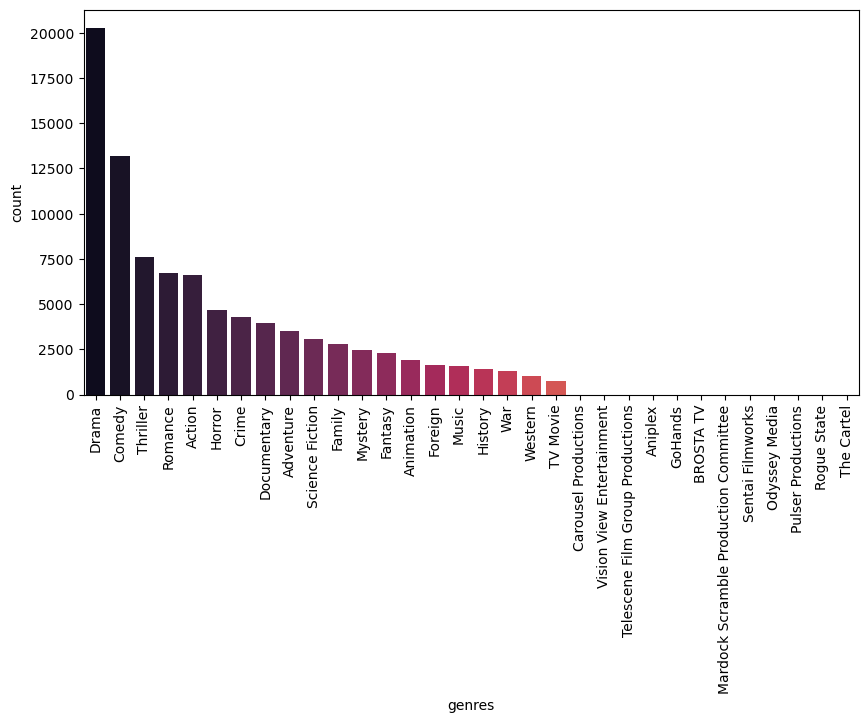

In [11]:
genres_counts_df = pd.DataFrame([contador_generos]).T.reset_index()
genres_counts_df.columns = ['genres', 'count']
genres_counts_df = genres_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='genres', y='count', data=genres_counts_df, palette='rocket')
plt.xticks(rotation=90)
plt.show()

La gráfica nos confirma lo que descubrimos anteriormente, `Drama` y `Comedia` son los géneros más populares mientras que los `War`, `Western`, and `TV Movie` son los menos populares.

#### Extrayendo el año del título de las películas


In [12]:
# Convertir la columna 'release_date' a datetime
movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')

movies['year'] = movies['release_date'].dt.year
movies.insert(15, 'year', movies.pop('year'))

In [13]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,year,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995.0,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995.0,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995.0,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995.0,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995.0,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


#### Cuántos años distintos están contenidos en nuestro dataset?


In [14]:
unique_years = movies['year'].nunique()
print(f"Total de años distintos en nuestro dataset: {unique_years}")

Total de años distintos en nuestro dataset: 135


Con este cálculo, nos percatamos que contamos con mas de 100 años en nuestro dataset. Lo que podemos hacer ahora es dividir nuestros datos en décadas para tener una idea en general de cuando fueron lanzadas las películas de nuestro dataset.

#### Cuál fue la década más popular para estrenar una película?

Analizemos el dataset para conocer el número de películas contenidas.

In [15]:
print(f"Numero total de peliculas en el dataset: {movies['id'].nunique()}")

Numero total de peliculas en el dataset: 45436


Ahora limpiemos nuestro dataset al eliminar todas las peliculas que contengan un `null` en el año.

In [16]:
movies = movies[~movies['year'].isnull()]
print(f"Total de peliculas despues de eliminar aquellas con null en el año:: {movies['id'].nunique()}")


Total de peliculas despues de eliminar aquellas con null en el año:: 45346


Esto nos dice que se eliminaron 90 películas que no contaba con un año de lanzamiento:

Existen dos formas de calcular la década de un año:

1. convertir el año a string y remplazar el último dígito con un 0

2. redondear el año al décimo (10) próximo

In [17]:
x = 1995

def calcular_decada(year):
    year = str(year)
    decade_prefix = year[0:3] # obtener los primeros 3 digitos de un año
    decade = f'{decade_prefix}0' # añadir un 0 al final
    return int(decade)

calcular_decada(x)

1990

In [18]:
def redondear(year):
    return year - (year%10)

redondear(x)

1990

Ambas funciones `calcular_decada()` y `redondear()` cumplen con el objetivo de identificar la decada de un año.

Podemos aplicar cualquiera de ellas a todos los años de nuestro dataset `movies` y al mismo tiempo crearemos una columna llamada `decade`.


In [19]:
movies['decade'] = movies['year'].apply(redondear)

### Paso 4: Transformando los datos

Para construir un sistema de recomendación con filtrado basado en contenido necesitamos preparar nuestro dataset de forma tal que las filas representen las películas y las columnas las características (géneros y décadas)


Primero, debemos manipular la columna de `generos` de forma tal que cada genero sea representado por una característica binaria (1 si pertenece a un determinado género, 0 si no pertenece)

In [20]:
genres = list(contador_generos.keys())

for g in genres:
    movies[g] = movies['genres'].transform(lambda x: int(g in x))

Analizando la estructura de los datos se desplieguan de la siguiente manera:

In [21]:
movies[genres].head()

,Animation,Comedy,Family,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,...,Telescene Film Group Productions,Aniplex,GoHands,BROSTA TV,Mardock Scramble Production Committee,Sentai Filmworks,Odyssey Media,Pulser Productions,Rogue State,The Cartel
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Con esto comprobamos que los géneros se representan como columnas con propiedades binarias. Ahora debemos asignar las distintas décadas a sus columnas correspondientes. Lo realizamos al utilizar la función `get_dummies()` de `pandas` al crear variables categóricas en variables binarias.

In [22]:
movie_decades = pd.get_dummies(movies['decade'])
movie_decades.head()

,1870.0,1880.0,1890.0,1900.0,1910.0,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0,2020.0
0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


Lo siguiente es crear un nuevo dataframe con las propiedades de de decada y genero de las peliculas en `movie_features`. Lo conseguimos al utilizar la funcion `concat` de pandas, al concatenar los generos y las decadas en un solo dataframe.

In [23]:
movie_features = pd.concat([movies[genres], movie_decades], axis=1)
movie_features.head()

,Animation,Comedy,Family,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,...,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0,2020.0
0,1,1,1,0,0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,False,False
1,0,0,1,1,1,0,0,0,0,0,...,False,False,False,False,False,False,True,False,False,False
2,0,1,0,0,0,1,0,0,0,0,...,False,False,False,False,False,False,True,False,False,False
3,0,1,0,0,0,1,1,0,0,0,...,False,False,False,False,False,False,True,False,False,False
4,0,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,False,False


El dataframe `movie_features` esta listo y contiene los datos que nos interesan. Ahora debemos de construir nuestro sistema de recomendación.

### Step 5: Construyendo un sistema de recomendacion de "Peliculas Parecidas" utilizando similitud Coseno

Para construir este sistema de recomendacion item-item utilizaremos una metrica llamada similitud coseno `cosine similarity`.

La similitud Coseno se basa en el coseno del angulo entre dos vectores (c.e., $A$ y $B$). Entre mas pequeño es el angulo, mayor es la similitud entre los vectores, y se calcula de la siguiente forma:

$$\cos(\theta) = \frac{A\cdot B}{||A|| ||B||}$$

En este ejercicio, utilizaremos la funcion de scikit-learn de `cosine_similarity` para generar la matriz de similitud de tipo $(n_{\text{movies}}, n_{\text{movies}})$. Esta matriz nos permitira extraer peliculas que sean parecidas a nuestra pelicula de interes.

In [24]:
cosine_sim = cosine_similarity(movie_features, movie_features)
print(f"Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: {cosine_sim.shape}")

Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: (45376, 45376)


Esto nos indica que al evaluar la similitud de coseno del dataframe `movie_features` en la funcion `cosine_similarity()` obtenemos una matriz de similitud del tipo $(n_{\text{movies}}, n_{\text{movies}})$.

Esta matriz contiene valores entre 0 y 1 que representan el angulo de similaridad entre las peliculas en los ejes x , y.


### Desarrollando una funcion que encuentre peliculas similares

Si por ejemplo queremos encontrar películas que sean similares a `X-men` en nuestro sistema de recomendación, necesitamos saber el título de una película en nuestro dataset.

Con el fin de que nuestro sistema sea más amigable para el usuario, utilizaremos un paquete llamado `fuzzywuzzy` que nos ayudará a encontrar el título de la película mas parecido a partir del string que le pasemos.

Con base en esto, crearemos una función que se llame `encuentra_pelicula()` que implementa el algoritmo de matching de strings de `fuzzywuzzy` para hallar el título mas parecido a partir de un string ingresado por el usuario.

In [33]:
!pip install fuzzywuzzy
from fuzzywuzzy import process


In [34]:
def encuentra_pelicula(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

Probemos la funcionalidad de la funcion `encuentra_pelicula()` al escribir equivocadamente la pelicula `X-Men`

In [35]:
title = encuentra_pelicula('x-men')
print(f"El titulo correcto de la pelicula es: {title}:")

El titulo correcto de la pelicula es: X-Men:


Ahora que ya no nos preocupamos por escribir mal el título de una película, lo que nos interesa es encontrar recomendaciones relevantes a partir de la película que deseamos.

Deseamos encontrar el índice de la película en la matriz de similitud coseno. Para identificar la fila en la cual debemos buscar podemos crear un mapeador de índices de películas que encuentre el titulo de una película y le asigne el índice que representa en nuestra matriz.

Crearemos un diccionario llamado `movie_idx` donde las llaves son los titulos de las peliculas y los valores son los indices de las peliculas.

In [36]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"El indice de la pelicula {title} en la matriz movie_idx es: {idx}")

El indice de la pelicula X-Men en la matriz movie_idx es: 3671


Al usar el diccionario `movie_idx`, sabemos que Jumanji se representa por el indice 1 en nuestra matriz.

Ahora tratemos de encontrar las 10 peliculas mas similares a Jumanji.

In [37]:
numero_recomendaciones=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(numero_recomendaciones+1)]
similar_movies = [i[0] for i in sim_scores]

`similar_movies` es un arreglo de indices que representa el top 10 de recomendaciones a partir de la pelicula elegida (en este caso X-Men). Podemos encontrar el títulos de las peliculas correspondientes al crear un mapeador invertido de `movie_idx` o usando `iloc` en la columna de título del dataframe `movies`.

In [38]:
print(f"Por que miraste la pelicula {title}, te pueden interesar las siguientes {numero_recomendaciones} peliculas:")
movies['title'].iloc[similar_movies]

Por que miraste la pelicula X-Men, te pueden interesar las siguientes 10 peliculas:


3675              The In Crowd
4570              Original Sin
4684          Don't Say a Word
6188            City of Ghosts
6406                On the Run
6457                   Purpose
7429                The Unsaid
9307              Black Plague
9401         The Galíndez File
9649    Assault on Precinct 13
Name: title, dtype: object

Podemos probar nuestro sistema con otros titulos de peliculas.

In [39]:
def obtener_recomendaciones_basadas_contenido(title_string, numero_recomendaciones=10):
    title = encuentra_pelicula(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(numero_recomendaciones+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Las peliculas recomendadas con base en la pelicula {title} son:")
    print(movies['title'].iloc[similar_movies])

In [41]:
obtener_recomendaciones_basadas_contenido('Shrek', 5)

Las peliculas recomendadas con base en la pelicula Shrek son:
4881          Charlotte Gray
13360          Passchendaele
31382    Battle of the Brave
16746           God on Trial
22236                 Ghetto
Name: title, dtype: object


# Recomendaciones finales:

## Repite todos los pasos contenidos en este proyecto con el dataset de tu proyecto.